# ML Notebook 1 - Overview & Logit

In [1]:
import sys
sys.path.append('../')
import glob2 as glob

import joblib
import copy
#import config
#import dota2api
import json
import requests
from pandas.io.json import json_normalize 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns
#import plotly.express as px

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


import warnings; warnings.simplefilter('ignore')

## Preprocessing

Here we will load in our data and encode our categorical data, i.e., the heroes picked and banned during the drafting phase for each match. 

In [2]:
# Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

SEED = 17 # random_state that I will be using

Load in our data. 

In [3]:
# Import Training and Test Data  
train_features = pd.read_csv('data2/dpc_train_features.csv', index_col='match_id')
train_targets = pd.read_csv('data2/dpc_train_target.csv', index_col='match_id')
test_features = pd.read_csv('data2/dpc_test_features.csv', index_col='match_id')
test_targets = pd.read_csv('data2/dpc_test_target.csv', index_col='match_id')

In [4]:
train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((1045, 66), (1045, 2), (117, 66), (117, 2))

### One Hot Encoding Features

Hot encoding by getting dummies for each of the 22 hero_id features

In [5]:
# Adapted OHE procedure from: https://www.kaggle.com/kuzand/dota-2-winner-prediction-multilayer-nn-pytorch#Things-to-do

all_features = pd.concat([train_features, test_features])

all_features_df = all_features.copy() # saving copy of the features before encoding for comparison later

# Index to split the training and test data sets
idx_split = train_features.shape[0]

# That is we will split back into train/test features after OHE. 
# df_train_features == all_features[:idx_split]
# df_test_features == all_features[idx_split:]

In [6]:
# Get dummies for all 22 'hero_id' columns

for i in range(1,23):
        all_features = pd.get_dummies(all_features, columns = [f'{i}hero_id'])

print(all_features.shape)

(1162, 2088)


In [7]:
all_features.head()

,1is_pick,1team,2is_pick,2team,3is_pick,3team,4is_pick,4team,5is_pick,5team,6is_pick,6team,7is_pick,7team,8is_pick,8team,9is_pick,9team,10is_pick,10team,11is_pick,11team,12is_pick,12team,13is_pick,13team,14is_pick,14team,15is_pick,15team,16is_pick,16team,17is_pick,17team,18is_pick,18team,19is_pick,19team,20is_pick,20team,21is_pick,21team,22is_pick,22team,1hero_id_2,1hero_id_3,1hero_id_4,1hero_id_6,1hero_id_7,1hero_id_9,1hero_id_10,1hero_id_16,1hero_id_18,1hero_id_19,1hero_id_23,1hero_id_25,1hero_id_27,1hero_id_29,1hero_id_31,1hero_id_33,1hero_id_37,1hero_id_38,1hero_id_40,1hero_id_41,1hero_id_42,1hero_id_43,1hero_id_46,1hero_id_52,1hero_id_53,1hero_id_55,1hero_id_57,1hero_id_58,1hero_id_59,1hero_id_60,1hero_id_61,1hero_id_62,1hero_id_65,1hero_id_66,1hero_id_68,1hero_id_69,1hero_id_71,1hero_id_72,1hero_id_73,1hero_id_74,1hero_id_75,1hero_id_76,1hero_id_79,1hero_id_80,1hero_id_81,1hero_id_82,1hero_id_83,1hero_id_84,1hero_id_85,1hero_id_86,1hero_id_87,1hero_id_88,1hero_id_89,1hero_id_90,1hero_id_91,1hero_id_93,...,22hero_id_1,22hero_id_2,22hero_id_4,22hero_id_5,22hero_id_6,22hero_id_7,22hero_id_8,22hero_id_10,22hero_id_11,22hero_id_12,22hero_id_13,22hero_id_14,22hero_id_15,22hero_id_16,22hero_id_17,22hero_id_18,22hero_id_19,22hero_id_21,22hero_id_22,22hero_id_23,22hero_id_25,22hero_id_26,22hero_id_27,22hero_id_28,22hero_id_29,22hero_id_32,22hero_id_33,22hero_id_34,22hero_id_35,22hero_id_36,22hero_id_37,22hero_id_38,22hero_id_39,22hero_id_40,22hero_id_41,22hero_id_42,22hero_id_43,22hero_id_44,22hero_id_45,22hero_id_46,22hero_id_47,22hero_id_48,22hero_id_49,22hero_id_50,22hero_id_51,22hero_id_52,22hero_id_53,22hero_id_54,22hero_id_55,22hero_id_56,22hero_id_57,22hero_id_58,22hero_id_59,22hero_id_60,22hero_id_61,22hero_id_62,22hero_id_63,22hero_id_65,22hero_id_67,22hero_id_68,22hero_id_70,22hero_id_71,22hero_id_72,22hero_id_73,22hero_id_74,22hero_id_75,22hero_id_76,22hero_id_77,22hero_id_78,22hero_id_79,22hero_id_80,22hero_id_81,22hero_id_82,22hero_id_84,22hero_id_85,22hero_id_86,22hero_id_88,22hero_id_89,22hero_id_92,22hero_id_93,22hero_id_94,22hero_id_95,22hero_id_96,22hero_id_97,22hero_id_98,22hero_id_99,22hero_id_101,22hero_id_102,22hero_id_104,22hero_id_106,22hero_id_107,22hero_id_108,22hero_id_109,22hero_id_110,22hero_id_112,22hero_id_113,22hero_id_114,22hero_id_120,22hero_id_121,22hero_id_129
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5115031896,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4865407245,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4889341660,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5050335216,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

Note that there are 117 unique heroes in Dota 2 (available in Captains Mode during patch 7.22), however, not all 117 available heroes were selected in this dataset for a given pick, e.g., 1pick which corresponds to the first hero banned in the draft. Therefore, columns will be less than 22 x 117.

### Set targets, features, and verification set 

In [8]:
# Encoded train/test features
# Try this once without scaling 

X_remainder = all_features[:idx_split] # our full training set 
X_test = all_features[idx_split:]

y_remainder = train_targets['radiant_win']
y_test = test_targets['radiant_win']

#y_remainder = train_targets.radiant_win.values
#y_test = test_targets.radiant_win.values

In [9]:
# Check to make sure everything is correct size
X_remainder.shape, y_remainder.shape, X_test.shape, y_test.shape

((1045, 2088), (1045,), (117, 2088), (117,))

Everything seems in order, let's do our validation split and get into the modelliing. 

### Train Validation Split

Train Validation Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

print(f'Shape of train features: {X_train.shape}')
print(f'Shape of train targets: {y_train.shape}')
print(f'Shape of validation features: {X_valid.shape}')
print(f'Shape of validation targest: {y_valid.shape}')

Shape of train features: (940, 2088)
Shape of train targets: (940,)
Shape of validation features: (105, 2088)
Shape of validation targest: (105,)


## Overview of Assorted Machine Learning Methods

Testing encoded data with an assortment of classifiers to get a rough idea about it's performance. 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

logreg = LogisticRegression(random_state=17)
forest = RandomForestClassifier(random_state=17)
bayes = MultinomialNB()
xg = XGBClassifier(random_state=17)

In [12]:
classifiers = [logreg, forest, xg, bayes]
acc_train = []
acc_test = []

In [13]:
%%time
#THIS CELL TAKES A WHILE TO RUN
for i in classifiers:
    X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.1, random_state = SEED)

    scores = cross_val_score(i, X_train, y_train, cv=5)
    acc_train.append(np.mean(scores))
    
    model = i.fit(X_train, y_train)
    #y_pred_valid = i.predict(X_valid)[:, 1]
    acc_test.append(model.score(X_valid, y_valid))

Wall time: 24.2 s


In [14]:
summary_base = pd.DataFrame({'models': classifiers,
              'Training Accuracy': acc_train,
              'Validation Accuracy': acc_test})
summary_base

,models,Training Accuracy,Validation Accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.490426,0.466667
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.484043,0.380952
2,"XGBClassifier(base_score=0.5, booster=None, co...",0.482979,0.419048
3,"MultinomialNB(alpha=1.0, class_prior=None, fit...",0.523404,0.466667


Since the logistic regression has among the highest accuracy using the entire encoded feature set, I will go with that and see how far this takes me. 

### Logit Model 1. 

Solver = lbfgs

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

In [17]:
#from sklearn.linear_model import LogisticRegression

validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logit = LogisticRegression(C = c,random_state=SEED)
    logit.fit(X_train,y_train)
    
    # train on traning set
    train_scores.append(logit.score(X_train,y_train))
    # score on validation set
    validation_scores.append(logit.score(X_valid,y_valid))

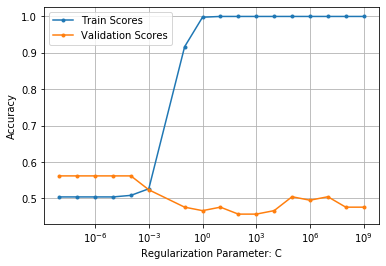

In [18]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')
plt.grid()
plt.show();

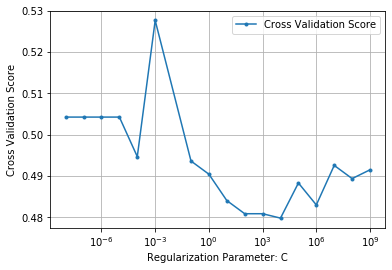

The best model has C =  0.001
Wall time: 9.85 s


In [19]:
%%time
#Store the results
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    logit = LogisticRegression(C=c,random_state=SEED, solver = 'lbfgs')
    
    #the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(logit, X_train, y_train, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

In [20]:
for i in range(len(cross_validation_scores)):
    print(f'Fold {i+1}: {cross_validation_scores[i]}')

Fold 1: 0.5042553191489362
Fold 2: 0.5042553191489362
Fold 3: 0.5042553191489362
Fold 4: 0.5042553191489362
Fold 5: 0.49468085106382975
Fold 6: 0.5276595744680851
Fold 7: 0.49361702127659574
Fold 8: 0.4904255319148936
Fold 9: 0.4840425531914893
Fold 10: 0.48085106382978726
Fold 11: 0.48085106382978726
Fold 12: 0.47978723404255313
Fold 13: 0.48829787234042554
Fold 14: 0.4829787234042553
Fold 15: 0.4925531914893616
Fold 16: 0.48936170212765956
Fold 17: 0.4914893617021277


In [21]:
print(f"Mean cross-validation accuracy: {np.mean(scores)}")

Mean cross-validation accuracy: 0.5234042553191489


In [22]:
logit1_tuned = LogisticRegression(C=0.001, penalty='l2', random_state=SEED, solver='lbfgs').fit(X_remainder, y_remainder)
logit1_tuned.score(X_test, y_test)

0.5128205128205128

In [23]:
y_pred = logit1_tuned.predict(X_test)
threshold= 0.5
y_pred_proba = logit1_tuned.predict_proba(X_test)[:,1] >= threshold
print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit1 test roc_auc score: 0.5054711246200608


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        63
           1       0.47      0.41      0.44        54

    accuracy                           0.51       117
   macro avg       0.51      0.51      0.50       117
weighted avg       0.51      0.51      0.51       117



In [26]:
y_pred

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1], dtype=int64)

In [50]:
logit1_tuned_confusion = confusion_matrix(y_test, y_pred)
logit1_tuned_confusion

array([[38, 25],
       [32, 22]])

Confusion matrix, without normalization
[[43 20]
 [35 19]]


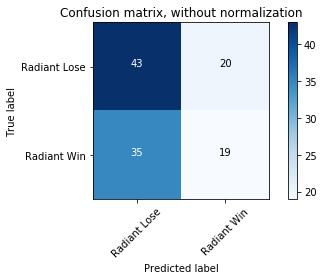

In [61]:
import itertools
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Radiant Lose','Radiant Win'],
                      title='Confusion matrix, without normalization')

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        63
           1       0.47      0.41      0.44        54

    accuracy                           0.51       117
   macro avg       0.51      0.51      0.50       117
weighted avg       0.51      0.51      0.51       117



In [30]:
coef = logit1_tuned.coef_
print(coef)

[[ 0.         -0.00539911  0.         ...  0.00053731  0.00048661
   0.00053197]]


Confusion matrix, without normalization
[[38 25]
 [32 22]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.59 0.41]]


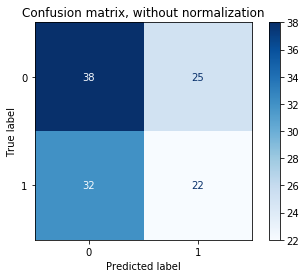

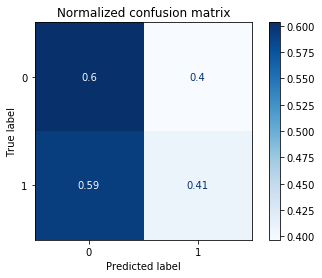

In [51]:
from sklearn.metrics import plot_confusion_matrix

classifier = logit1_tuned
#class_names = test_targets_names

#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [91]:
joblib.dump(logit1_tuned, 'logit1_tuned.pkl')

['logit1_tuned.pkl']

In [21]:
logit1_tuned = joblib.load('logit1_tuned.pkl')

In [22]:
logit1_tuned.confusion_matrix(y_test, y_pred)

AttributeError: 'LogisticRegression' object has no attribute 'confusion_matrix'

In [20]:
from sklearn.metrics import plot_confusion_matrix

classifier = logit1_tuned1.fit(X_remainder, y_remainder)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

NameError: name 'class_names' is not defined

### Logit Model 2.

Solver = liblinear

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

In [53]:
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

grid={'C':C_range, 'penalty':['l1','l2']}
logit2 = LogisticRegression(solver='liblinear', random_state=SEED)
logit2_cv = GridSearchCV(logit2, grid, cv=5)

logit2_cv.fit(X_train, y_train)

print("tuned hyperparameters: (best param))", logit2_cv.best_params_)
print("accuracy :", logit2_cv.best_score_)

tuned hyperparameters: (best param)) {'C': 0.0001, 'penalty': 'l2'}
accuracy : 0.5276595744680851


In [54]:
logit2_tuned = LogisticRegression(C=0.0001, penalty='l2', random_state=SEED, solver='liblinear').fit(X_remainder, y_remainder)
logit2_tuned.score(X_test,y_test)

0.5299145299145299

In [55]:
y_pred = logit2_tuned.predict(X_test)
threshold= 0.5
y_pred_proba = logit2_tuned.predict_proba(X_test)[:,1] >= threshold
print(f'Final Logit2 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit2 test roc_auc score: 0.5192307692307693


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.68      0.61        63
           1       0.49      0.35      0.41        54

    accuracy                           0.53       117
   macro avg       0.52      0.52      0.51       117
weighted avg       0.52      0.53      0.52       117



Confusion matrix, without normalization
[[43 20]
 [35 19]]
Normalized confusion matrix
[[0.68 0.32]
 [0.65 0.35]]


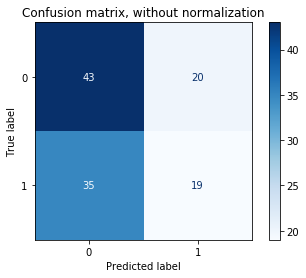

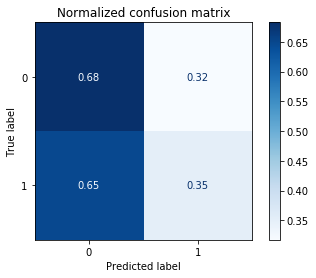

In [60]:
from sklearn.metrics import plot_confusion_matrix

classifier = logit2_tuned
#class_names = test_targets_names

#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [95]:
joblib.dump(logit2_tuned, 'logit2_tuned.pkl')

['logit2_tuned.pkl']

### Logit Model 3. 

For comparison, let's compare out of the box results after scaling the data. Scaling data after the two splits to avoid data leakage.

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train1, X_valid1, X_test1 = X_train.copy(), X_valid.copy(), X_test.copy()

X_train_scaled = scaler.fit_transform(X_train1)
X_valid_scaled = scaler.fit_transform(X_valid1)
X_test_scaled = scaler.fit_transform(X_test1)

In [69]:
logit1 = LogisticRegression(random_state= SEED, n_jobs=-1)

In [56]:
%%time
logit1.fit(X_train_scaled, y_train)
y_pred = logit1.predict(X_valid)
y_pred_proba = logit1.predict_proba(X_valid_scaled)[:, 1]

print(f"Accuracy Score on Train Set: {logit1.score(X_train_scaled, y_train)}")
print(f"Accuracy Score on validation Set: {logit1.score(X_valid_scaled, y_valid)}")
print(f'Log Regression validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

Accuracy Score on Train Set: 0.9968085106382979
Accuracy Score on validation Set: 0.4666666666666667
Log Regression validation roc_auc score: 0.4660740203193033
Wall time: 3.81 s


Wow what a surprise, since all of the features are 0 or 1 scaling doesn't do anything. 

### Logit Model 4. 

In [72]:
#Settling a CV scheme.
cv = ShuffleSplit(n_splits=5, random_state=SEED) #using a shuffle split for CV 

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

In [74]:
#from sklearn.linear_model import LogisticRegression

validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logit = LogisticRegression(C = c,random_state=SEED)
    logit.fit(X_train,y_train)
    
    # train on training set
    train_scores.append(logit.score(X_train,y_train))
    # score on validation set
    validation_scores.append(logit.score(X_valid,y_valid))

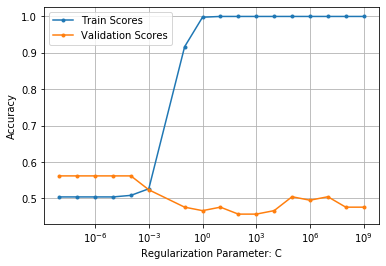

In [75]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')
plt.grid()
plt.show();

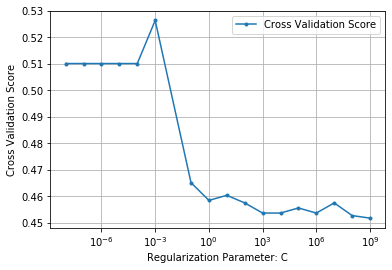

The best model has C =  0.001
Wall time: 11.8 s


In [80]:
%%time
#Store the results
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    logit = LogisticRegression(C=c,random_state=SEED, solver = 'lbfgs')
    
    #the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(logit, X_remainder, y_remainder, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

In [81]:
for i in range(len(cross_validation_scores)):
    print(f'Fold {i+1}: {cross_validation_scores[i]}')

Fold 1: 0.5100478468899521
Fold 2: 0.5100478468899521
Fold 3: 0.5100478468899521
Fold 4: 0.5100478468899521
Fold 5: 0.5100478468899521
Fold 6: 0.5263157894736842
Fold 7: 0.4650717703349282
Fold 8: 0.4583732057416269
Fold 9: 0.46028708133971286
Fold 10: 0.4574162679425838
Fold 11: 0.4535885167464115
Fold 12: 0.4535885167464115
Fold 13: 0.4555023923444976
Fold 14: 0.4535885167464115
Fold 15: 0.4574162679425838
Fold 16: 0.4526315789473684
Fold 17: 0.45167464114832534


In [82]:
print(f"Average Score:{np.mean(scores)}")

Average Score:0.5234042553191489


In [83]:
# Final Evaluation: logit1

C = 0.001
penalty = 'l2'
max_iter = 100
solver = 'lbfgs'
random_state = SEED
n_jobs = -1
verbose = 0
class_weight = 'balanced'

final_logit1 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)

In [112]:
#final_logit1 = LogisticRegression(C=0.001, random_state=SEED, n_jobs=-1, solver='lbfgs')
final_logit1.fit(X_remainder, y_remainder)
final_logit1.score(X_test, y_test)
print(f'Final Logit1 test score: {final_logit1.score(X_test, y_test)}')
#print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit1 test score: 0.5128205128205128


In [121]:
y_pred = final_logit1.predict(X_test)
y_pred_proba = final_logit1.predict_proba(X_test)
#print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

In [122]:
print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit1 test roc_auc score: 0.5054711246200608
